# Estimating Coordinated Daily Activity Patterns

This notebook illustrates how to re-estimate ActivitySim's CDAP model. This process 
includes running ActivitySim in estimation mode to read household travel survey files and write out
the estimation data bundles used in this notebook.  To review how to do so, please visit the other
notebooks in this directory.

# Load libraries

In [1]:
import numpy as np
import pandas as pd
import larch
import os
import matplotlib.pyplot as plt

pd.options.display.max_columns = 150

In [2]:
os.chdir('C:\ABM3_dev\outputs')

In [3]:
persons = pd.read_csv(r'output\final_persons.csv')
households = pd.read_csv(r'output\final_households.csv')
tours = pd.read_csv(r'output\final_tours.csv')
or_persons = pd.read_csv(r'C:\ABM3_dev\run_data\data_2z_series15\override_persons.csv')
or_households = pd.read_csv(r'C:\ABM3_dev\run_data\data_2z_series15\override_households.csv')
or_tours = pd.read_csv(r'C:\ABM3_dev\run_data\data_2z_series15\override_tours.csv')

C:\Users\davidh\AppData\Local\Temp\4\ipykernel_28808\4030097866.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  persons = pd.read_csv(r'output\final_persons.csv')
C:\Users\davidh\AppData\Local\Temp\4\ipykernel_28808\4030097866.py:4: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  or_persons = pd.read_csv(r'C:\ABM3_dev\run_data\data_2z_series15\override_persons.csv')
C:\Users\davidh\AppData\Local\Temp\4\ipykernel_28808\4030097866.py:6: DtypeWarning: Columns (20,22) have mixed types. Specify dtype option on import or set low_memory=False.
  or_tours = pd.read_csv(r'C:\ABM3_dev\run_data\data_2z_series15\override_tours.csv')


In [4]:
cdap_dir = r'output\estimation_data_bundle\cdap'
full_edb = pd.read_csv(os.path.join(cdap_dir, 'cdap_values_combined_full.csv'))

C:\Users\davidh\AppData\Local\Temp\4\ipykernel_28808\2743892615.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  full_edb = pd.read_csv(os.path.join(cdap_dir, 'cdap_values_combined_full.csv'))


## Pre-processing CDAP data for estimation
CDAP in the raw estimation data bundle out of ActivitySim is not representative of people's actual CDAP pattern.  It includes households and people that may not have completed that particular survey day and has their CDAP determined after a bunch of trip and tour filtering.  For estimation, we only want households with a full survey day completed and want their CDAP before any tours or trips were removed.

To do this, we overwrite the "override_choice" column in the estimation data bundle and take only persons who have a non-zero day weight (which is only true if the whole household survey day is complete)

In [5]:
print("Original distributions:")
pd.crosstab(full_edb.cdap_activity, full_edb.survey_year, normalize='columns', margins=True).round(3)

Original distributions:


survey_year,2016,2022,All
cdap_activity,,,
H,0.740,0.303,0.690
M,0.124,0.181,0.131
N,0.135,0.515,0.179


In [6]:
hhs_with_missing_model_choice = full_edb[full_edb.model_choice.isna()].household_id.unique()
print(len(hhs_with_missing_model_choice))
households['person_count'] = persons.groupby(['household_id']).person_id.count().values
assert (persons.groupby(['household_id']).person_id.count().index == households.household_id).all()
hhs_with_hhsize_not_correct = households[households.person_count != households.hhsize].household_id.unique()
print(len(hhs_with_hhsize_not_correct))
# difference is households with hhsize > 5

435
438


In [7]:
print("Number of total people in full EDB:", len(full_edb))

# taking only people who have a model_choice (can be na if hhsize != num people) and people who have a non-zero day weight
full_edb['person_day_weight'] = full_edb.person_id.map(or_persons.set_index('person_id').person_day_weight.to_dict())
df = full_edb[(~full_edb.model_choice.isna()) & (full_edb.person_day_weight > 0)].copy()

df['override_choice'] = df.person_id.map(or_persons.set_index('person_id').cdap_activity_raw.to_dict())

print("Number after filtering:", len(df))

Number of total people in full EDB: 96881
Number after filtering: 41638


In [8]:
for survey_year in df.survey_year.unique():
    print(f"Unweighted CDAP counts for {survey_year}")
    tmp = df[(df.survey_year == survey_year) & (df.person_day_weight > 0)]
    tmp_ct = pd.crosstab(tmp.ptype, tmp.override_choice, margins=True)
    display(tmp_ct.fillna(0).astype(int))
    for col in tmp_ct.columns:
        tmp_ct[col] = tmp_ct[col] / tmp_ct.All
    display((tmp_ct * 100).round(1))

Unweighted CDAP counts for 2016


override_choice,H,M,N,All
ptype,,,,
1,797,8829,5201,14827
2,251,1189,1357,2797
3,201,968,616,1785
4,886,0,2917,3803
5,853,0,2899,3752
6,108,244,66,418
7,734,2080,795,3609
8,596,449,649,1694
All,4426,13759,14500,32685


override_choice,H,M,N,All
ptype,,,,
1,5.4,59.5,35.1,100.0
2,9.0,42.5,48.5,100.0
3,11.3,54.2,34.5,100.0
4,23.3,0.0,76.7,100.0
5,22.7,0.0,77.3,100.0
6,25.8,58.4,15.8,100.0
7,20.3,57.6,22.0,100.0
8,35.2,26.5,38.3,100.0
All,13.5,42.1,44.4,100.0


Unweighted CDAP counts for 2022


override_choice,H,M,N,All
ptype,,,,
1,696,1443,2261,4400
2,88,212,259,559
3,101,111,161,373
4,161,0,377,538
5,693,0,1746,2439
6,19,17,14,50
7,99,203,111,413
8,89,47,45,181
All,1946,2033,4974,8953


override_choice,H,M,N,All
ptype,,,,
1,15.8,32.8,51.4,100.0
2,15.7,37.9,46.3,100.0
3,27.1,29.8,43.2,100.0
4,29.9,0.0,70.1,100.0
5,28.4,0.0,71.6,100.0
6,38.0,34.0,28.0,100.0
7,24.0,49.2,26.9,100.0
8,49.2,26.0,24.9,100.0
All,21.7,22.7,55.6,100.0


In [9]:
for survey_year in df.survey_year.unique():
    print(f"Weighted CDAP counts for {survey_year}")
    tmp = df[df.survey_year == survey_year]
    tmp_ct = pd.crosstab(tmp.ptype, tmp.override_choice, margins=True, values=tmp.person_day_weight, aggfunc='sum')
    display(tmp_ct.fillna(0).astype(int))
    for col in tmp_ct.columns:
        tmp_ct[col] = tmp_ct[col] / tmp_ct.All
    display((tmp_ct * 100).round(1))

Weighted CDAP counts for 2016


override_choice,H,M,N,All
ptype,,,,
1,84985,682847,367808,1135642
2,20523,118266,96786,235576
3,28354,131260,64475,224090
4,107740,0,240631,348372
5,111288,0,202232,313521
6,16160,48559,10696,75417
7,80111,255392,80648,416151
8,62658,43273,67832,173764
All,511823,1279600,1131113,2922537


override_choice,H,M,N,All
ptype,,,,
1,7.5,60.1,32.4,100.0
2,8.7,50.2,41.1,100.0
3,12.7,58.6,28.8,100.0
4,30.9,NaN,69.1,100.0
5,35.5,NaN,64.5,100.0
6,21.4,64.4,14.2,100.0
7,19.3,61.4,19.4,100.0
8,36.1,24.9,39.0,100.0
All,17.5,43.8,38.7,100.0


Weighted CDAP counts for 2022


override_choice,H,M,N,All
ptype,,,,
1,153159,451805,550580,1155545
2,26692,93755,95804,216251
3,35647,47705,80577,163930
4,51640,0,98712,150353
5,139136,0,279148,418284
6,25194,24131,24084,73410
7,79859,191761,77433,349053
8,70976,52372,28530,151879
All,582305,861532,1234872,2678710


override_choice,H,M,N,All
ptype,,,,
1,13.3,39.1,47.6,100.0
2,12.3,43.4,44.3,100.0
3,21.7,29.1,49.2,100.0
4,34.3,NaN,65.7,100.0
5,33.3,NaN,66.7,100.0
6,34.3,32.9,32.8,100.0
7,22.9,54.9,22.2,100.0
8,46.7,34.5,18.8,100.0
All,21.7,32.2,46.1,100.0


In [10]:
df.override_choice.value_counts(normalize=True)

N    0.467698
M    0.379269
H    0.153033
Name: override_choice, dtype: float64

In [11]:
full_edb.override_choice.value_counts(normalize=True)

H    0.689836
N    0.179323
M    0.130841
Name: override_choice, dtype: float64

In [12]:
# Creating expressions that need to use numpy since larch estimation code doesn't parse it well
df['tmp_base_work_mc_logsum'] = np.where((df.is_external_worker == True), df.external_workplace_location_logsum.fillna(0), df.workplace_location_logsum.fillna(0))
df['tmp_ptype1_work_mc_logsum'] = (df.ptype == 1) * np.where((df.is_external_worker == True), df.external_workplace_location_logsum.fillna(0), df.workplace_location_logsum.fillna(0))
df['tmp_ptype2_work_mc_logsum'] = (df.ptype == 2) * np.where((df.is_external_worker == True), df.external_workplace_location_logsum.fillna(0), df.workplace_location_logsum.fillna(0))
df['tmp_ptype3_school_mc_logsum'] = np.where((df.ptype == 3)  & (df.school_zone_id > 0), df.school_modechoice_logsum, 0)
df['tmp_ptype6_school_mc_logsum'] = np.where((df.ptype == 6)  & (df.school_zone_id > 0), df.school_modechoice_logsum, 0)
df['tmp_ptype7_school_mc_logsum'] = np.where((df.ptype == 7)  & (df.school_zone_id > 0), df.school_modechoice_logsum, 0)

In [13]:
df['non_mand_accessibility'] = (df.shopping_accessibility + df.othdiscr_accessibility) / 2

In [14]:
print("Recoding a couple of work from home M patterns to N to satisfy constraints in model:")
# this can happen becuase we calculate the raw CDAP before any filtering is done
display(df[(df.work_from_home) & (df.is_student == False) ].override_choice.value_counts())
df.loc[(df.work_from_home) & (df.is_student == False) & (df.override_choice == 'M'), 'override_choice'] = 'N'

Recoding a couple of work from home M patterns to N to satisfy constraints in model:


N    1659
H     554
M       8
Name: override_choice, dtype: int64

In [15]:
df.to_csv(os.path.join(cdap_dir, 'cdap_values_combined.csv'), index=False)

In [16]:
spec = pd.read_csv(os.path.join(cdap_dir, 'cdap_INDIV_AND_HHSIZE1_SPEC.csv'))
coeffs = spec[['M', 'N', 'H']].melt(value_name='coefficient_name')
coeffs = coeffs[~coeffs.coefficient_name.isna()].drop(columns='variable').drop_duplicates(subset='coefficient_name', keep='first')
coeffs['value'] = 0.0
coeffs['constrain'] = 'F'
coeffs.set_index('coefficient_name', inplace=True)
coeffs.loc['coef_UNAVAILABLE'] = (-999.0, 'T')
coeffs.to_csv(os.path.join(cdap_dir, 'coef_helper.csv'))

# Load data and prep model for estimation

In [17]:
modelname = "cdap"

# import importlib
# importlib.reload(activitysim.estimation.larch)
from activitysim.estimation.larch import component_model
model, data = component_model(modelname, return_data=True)

c:\abm3_dev\activitysim\activitysim\estimation\larch\cdap.py:390: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(os.path.join(edb_directory, filename), **kwargs)


Including joint tour utiltiy?: False


one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>
one-hot encoding choice array
converting data_ch to <class 'numpy.float64'>


# Review Inputs

## Settings

In [18]:
# data.settings

## Households

In [19]:
data.households

,household_id,home_zone_id,income,hhsize,HHT,auto_ownership,num_workers,children,day,bldgsz,res_type,transponder_ownership,survey_year,day.1,HH_ID,chauf_id1,chauf_id2,child_id1,child_id2,child_id3,school_escorting_outbound,school_escorting_inbound,school_escorting_outbound_cond,joint_tour_frequency,joint_tour_frequency_composition,has_joint_tour,sample_rate,income_in_thousands,income_segment,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_6_to_12,num_children_5_to_15,num_children_16_to_17,num_gradeschool,num_highschool,num_college_age,num_young_adults,num_predrive_child,num_nonworker_adults,num_university_students,num_fullTime_workers,num_partTime_workers,num_retired_adults,num_highschool_graduates,num_children_6_to_15,num_young_retirees,num_old_retirees,non_family,family,home_is_urban,home_is_rural,num_hh_in_zone,ebike_owner,av_ownership,workplace_location_accessibility,shopping_accessibility,othdiscr_accessibility,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model
0,1,13119,52015.00,4,1,2,1,2,1,2,1,False,2016,1,161000385,2.0,1.0,4.0,3.0,NaN,1,1,1,0_tours,0,0.0,1,52.01500,2,3,2,2,2,0,1,2,0,2,1,0,0,2,1,0,0,1,0,2,2,0,0,False,True,True,False,14,False,False,10.802372,11.240395,14.904708,0.0,0,4,2,0,2,4,False
1,2,19303,36763.75,2,1,2,0,0,1,2,1,False,2016,1,161000451,NaN,NaN,NaN,NaN,NaN,1,1,1,0_tours,0,0.0,1,36.76375,2,2,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,1,0,False,True,False,True,7,False,False,10.393767,11.331872,13.462118,0.0,0,2,2,0,0,2,False
2,3,12446,15717.50,1,4,1,0,0,1,8,4,False,2016,1,161000525,NaN,NaN,NaN,NaN,NaN,1,1,1,0_tours,0,0.0,1,15.71750,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,True,False,True,False,14,False,False,11.392431,12.200212,14.323514,0.0,0,1,1,0,0,1,False
3,4,2699,35345.00,2,1,3,2,0,1,2,1,False,2016,1,161000914,NaN,NaN,NaN,NaN,NaN,1,1,1,0_tours,0,0.0,1,35.34500,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,0,0,False,True,True,False,7,False,False,11.416508,11.790192,15.674709,0.0,0,1,1,0,0,1,False
4,5,13161,31491.25,2,1,1,0,0,1,2,1,False,2016,1,161001149,NaN,NaN,NaN,NaN,NaN,1,1,1,1_Eat,7,1.0,1,31.49125,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,1,1,False,True,True,False,7,False,False,11.465833,11.161626,14.039745,0.0,0,2,2,0,0,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49757,49758,5406,23432.00,2,1,1,1,0,4,8,3,False,2022,4,22118046,NaN,NaN,NaN,NaN,NaN,1,1,1,0_tours,0,0.0,1,23.43200,1,1,2,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,0,0,False,True,True,False,1,False,False,10.984604,11.977773,14.545850,0.0,0,0,0,0,0,0,False
49758,49759,11721,31903.00,1,6,1,1,0,4,2,1,False,2022,4,22118047,NaN,NaN,NaN,NaN,NaN,1,1,1,0_tours,0,0.0,1,31.90300,2,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,True,False,True,False,1,False,False,10.968508,10.227038,14.174916,0.0,0,0,0,0,0,0,False
49759,49760,7270,83751.00,1,6,1,1,0,4,3,2,False,2022,4,22118053,NaN,NaN,NaN,NaN,NaN,1,1,1,0_tours,0,0.0,1,83.75100,3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,True,False,True,False,4,False,False,10.897590,11.095883,14.620244,0.0,0,0,0,0,0,0,False
49760,49761,2490,16453.00,1,6,1,1,0,4,8,3,True,2022,4,22118054,NaN,NaN,NaN,NaN,NaN,1,1,1,0_tours,0,0.0,1,16.45300,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,True,False,True,False,11,False,False,12.116374,13.626642,16.479234,0.0,0,1,1,0,0,1,False


## Person Data

In [20]:
data.person_data

,person_id,model_choice,override_choice,household_id,PNUM,age,sex,pemploy,pstudent,is_student,ptype,school_zone_id,workplace_zone_id,free_parking_at_work,work_from_home,telecommute_frequency,day,educ,external_worker_identification,external_workplace_zone_id,transit_pass_subsidy,transit_pass_ownership,industry,cdap_activity,mandatory_tour_frequency,_escort,_shopping,_othmaint,_eatout,_social,_othdiscr,non_mandatory_tour_frequency,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_preschool,is_gradeschool,is_highschool,is_university,school_segment,is_worker,is_fulltime_worker,is_parttime_worker,is_internal_worker,is_external_worker,home_zone_id,time_factor_work,time_factor_nonwork,naics_code,is_income_less25K,is_income_25K_to_60K,is_income_60K_to_120K,is_income_greater60K,is_income_greater120K,is_non_worker_in_HH,is_all_adults_full_time_workers,is_pre_drive_child_in_HH,is_out_of_home_worker,external_workplace_location_logsum,external_workplace_modechoice_logsum,school_location_logsum,school_modechoice_logsum,distance_to_school,...,othercollegeenroll,adultschenrl,ech_dist,hch_dist,pseudomsa,parkarea,hstallsoth,hstallssam,hparkcost,numfreehrs,dstallsoth,dstallssam,dparkcost,mstallsoth,mstallssam,mparkcost,parkactive,openspaceparkpreserve,beachactive,budgetroom,economyroom,luxuryroom,midpriceroom,upscaleroom,hotelroomtotal,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations,totint,duden,empden,popden,retempden,totintbin,empdenbin,dudenbin,PopEmpDenPerMi,TAZ,poe_id,external_work,external_nonwork,external_TAZ,external_MAZ,walk_dist_local_bus,walk_dist_premium_transit,ML_DIST,AVGTTS,PCTDETOUR,terminal_time,household_density,population_density,employment_density,density_index,is_cbd,tot_collegeenroll,is_parking_zone,exp_hourly,exp_daily,exp_monthly,chunk_id,person_day_weight,tmp_base_work_mc_logsum,tmp_ptype1_work_mc_logsum,tmp_ptype2_work_mc_logsum,tmp_ptype3_school_mc_logsum,tmp_ptype6_school_mc_logsum,tmp_ptype7_school_mc_logsum,non_mand_accessibility,cdap_rank
0,1,N,N,1,1,48,2,2,3,False,2,-1,5476,True,False,No_Telecommute,1,13,1,-1,0,0,healthcare,N,NaN,1,0,0,1,0,1,96,False,True,True,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,0,True,False,True,True,False,13119,0.407362,0.648903,0,False,True,False,False,False,True,False,True,True,NaN,NaN,NaN,NaN,NaN,...,0,0,432801,432801,3,3,0,0,0.000000,0,0,0,0.000000,0,0,0.000000,0.0000,0.0000,0.0,0,0,0,0,0,0,1,4,7.8278,22.4448,22.4448,22.4448,120,0,0,46,4.2780,0.1737,12.2946,0.0000,1,1,1,7979.7289,2439,NaN,0,0,NaN,NaN,9999.000,9999.000,0.4980,0.90330,0.11134,0,4.856359,13.856216,0.178215,0.171907,False,0,True,0.000000,0.000000,0.000000,0,67.171900,-0.957668,-0.000000,-0.957668,0.0,0.0,0.000000,13.072552,1
1,2,N,N,1,2,53,1,3,3,False,4,-1,-1,False,False,NaN,1,13,1,-1,0,0,NaN,N,NaN,0,0,0,0,0,1,1,False,True,True,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,0,False,False,False,False,False,13119,0.279769,0.612654,0,False,True,False,False,False,True,False,True,False,NaN,NaN,NaN,NaN,NaN,...,0,0,432801,432801,3,3,0,0,0.000000,0,0,0,0.000000,0,0,0.000000,0.0000,0.0000,0.0,0,0,0,0,0,0,1,4,7.8278,22.4448,22.4448,22.4448,120,0,0,46,4.2780,0.1737,12.2946,0.0000,1,1,1,7979.7289,2439,NaN,0,0,NaN,NaN,9999.000,9999.000,0.4980,0.90330,0.11134,0,4.856359,13.856216,0.178215,0.171907,False,0,True,0.000000,0.000000,0.000000,0,67.171900,0.000000,0.000000,0.000000,0.0,0.0,0.000000,13.072552,4
2,3,H,M,1,3,15,2,4,1,True,7,7056,-1,False,False,NaN,1,0,1,-1,0,0,NaN,M,school1,0,0,0,0,0,0,0,False,False,False,False,True,True,False,False,False,True,False,True,False,False,False,False,False,True,False,3,False,False,False,False,False,13119,0.412113,1.453034,0,False,True,False,False,False,True,False,True,False,NaN,NaN,

In [21]:
data.person_data.workplace_modechoice_logsum.value_counts()

-0.957668    1
-1.268617    1
-0.751905    1
-4.054370    1
-1.904136    1
            ..
-0.883704    1
-4.215500    1
-1.286365    1
-2.906404    1
-1.693392    1
Name: workplace_modechoice_logsum, Length: 18649, dtype: int64

In [22]:
data.person_data.tmp_ptype1_work_mc_logsum.value_counts()

-0.000000    25924
-2.697884        1
-1.191527        1
 1.412901        1
-1.123851        1
             ...  
-1.535464        1
 3.944422        1
-1.667221        1
-8.544604        1
-1.693392        1
Name: tmp_ptype1_work_mc_logsum, Length: 15715, dtype: int64

In [23]:
(data.person_data.override_choice == data.person_data.cdap_activity).all()

False

In [24]:
df = data.person_data.copy()
df['mand_status'] = np.select(condlist=[df.is_worker, df.is_student, (df.is_worker & df.is_student), ~(df.is_worker | df.is_student)], choicelist=['worker', 'student', 'both', 'neither'])
pd.crosstab(df.mand_status, df.override_choice, margins=True)

override_choice,H,M,N,All
mand_status,,,,
neither,2593,0,7939,10532
student,1866,3741,2179,7786
worker,1913,12043,9364,23320
All,6372,15784,19482,41638


In [25]:
pd.crosstab(df.ptype, df.override_choice, margins=True)

override_choice,H,M,N,All
ptype,,,,
1,1493,10265,7469,19227
2,339,1400,1617,3356
3,302,1079,777,2158
4,1047,0,3294,4341
5,1546,0,4645,6191
6,127,261,80,468
7,833,2283,906,4022
8,685,496,694,1875
All,6372,15784,19482,41638


In [26]:
pd.crosstab(df.telecommute_frequency, df.override_choice, margins=True)

override_choice,H,M,N,All
telecommute_frequency,,,,
1_day_week,119,1755,810,2684
2_3_days_week,163,428,522,1113
4_days_week,122,226,334,682
No_Telecommute,622,9475,4073,14170
All,1026,11884,5739,18649


In [27]:
df.shopping_accessibility.describe()

count    41638.000000
mean        11.472387
std          1.573167
min          1.721151
25%         10.652247
50%         11.481869
75%         12.410834
max         18.837816
Name: shopping_accessibility, dtype: float64

In [28]:
def create_N_by_access(df, bins=10):
    df['non_mand_access'] = (df.shopping_accessibility + df.othdiscr_accessibility) / 2
    df['non_mand_access_binned'], bins = pd.cut(df.non_mand_access, bins=10, retbins=True)
    df['N_cdap'] = np.where(df.override_choice == 'N', 1, 0)
    N_by_access = df.groupby('non_mand_access_binned').agg({'person_id': 'count', 'N_cdap': 'sum'}).rename(columns={'person_id': 'num_persons'})
    N_by_access['percent_N'] = (N_by_access.N_cdap / N_by_access.num_persons).round(3) * 100
    return N_by_access

def create_M_by_access(df, bins=10):
    df['non_mand_access'] = (df.shopping_accessibility + df.othdiscr_accessibility) / 2
    df['non_mand_access_binned'], bins = pd.cut(df.non_mand_access, bins=10, retbins=True)
    df['M_cdap'] = np.where(df.override_choice == 'M', 1, 0)
    M_by_access = df.groupby('non_mand_access_binned').agg({'person_id': 'count', 'M_cdap': 'sum'}).rename(columns={'person_id': 'num_persons'})
    M_by_access['percent_M'] = (M_by_access.M_cdap / M_by_access.num_persons).round(3) * 100
    return M_by_access

,num_persons,M_cdap,percent_M
non_mand_access_binned,,,
"(4.647, 6.366]",57,11,19.3
"(6.366, 8.067]",328,72,22.0
"(8.067, 9.768]",550,135,24.5
"(9.768, 11.47]",2128,703,33.0
"(11.47, 13.171]",16721,6336,37.9
"(13.171, 14.872]",13894,5484,39.5
"(14.872, 16.574]",5849,2299,39.3
"(16.574, 18.275]",1258,494,39.3
"(18.275, 19.976]",764,220,28.8


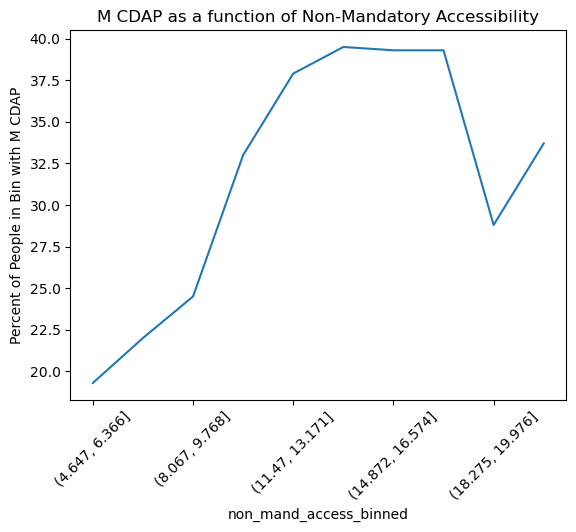

In [29]:
M_by_access_total = create_M_by_access(df, bins=10)
display(M_by_access_total)
M_by_access_total.percent_M.plot()
plt.xticks(rotation=45)
plt.ylabel('Percent of People in Bin with M CDAP')
plt.title('M CDAP as a function of Non-Mandatory Accessibility')
plt.show()

In [30]:
data.person_data.non_mand_accessibility.value_counts(dropna=False)

12.399662    63
10.469374    59
12.007919    58
13.154369    58
7.812076     57
             ..
12.744031     1
8.214301      1
12.948891     1
14.487324     1
12.303846     1
Name: non_mand_accessibility, Length: 6853, dtype: int64

In [31]:
# N_by_access_total = create_N_by_access(df[df.work_from_home], bins=10)
# display(N_by_access_total)
# N_by_access_total.percent_N.plot()
# plt.xticks(rotation=45)
# plt.ylabel('Percent of People in Bin with N CDAP')
# plt.title('N CDAP as a function of Non-Mandatory Accessibility')
# plt.show()

In [32]:
# N_by_access_total = create_N_by_access(df, bins=10)
# display(N_by_access_total)
# N_by_access_total.percent_N.plot()
# plt.xticks(rotation=45)
# plt.ylabel('Percent of People in Bin with N CDAP')
# plt.title('N CDAP as a function of Non-Mandatory Accessibility')
# plt.show()

In [33]:
# N_by_access_2016 = create_N_by_access(df[df.survey_year == 2016], bins=10)
# display(N_by_access_2016)
# N_by_access_2016.percent_N.plot()
# plt.xticks(rotation=45)
# plt.ylabel('Percent of People in Bin with N CDAP')
# plt.title('N CDAP vs Non-Mandatory Accessibility: 2016')
# plt.show()

In [34]:
# N_by_access_2016 = create_N_by_access(df[(df.auto_ownership > 0) & (df.auto_ownership >= df.num_workers)], bins=10)
# display(N_by_access_2016)
# N_by_access_2016.percent_N.plot()
# plt.xticks(rotation=45)
# plt.ylabel('Percent of People in Bin with N CDAP')
# plt.title('N CDAP vs Non-Mandatory Accessibility')
# plt.show()

## interaction_coef

In [35]:
data.interaction_coef

,activity,interaction_ptypes,coefficient,cardinality,slug
0,H,11,0,2,HH11
1,H,12,0,2,HH12
2,H,13,0,2,HH13
3,H,14,0,2,HH14
4,H,15,0,2,HH15
...,...,...,...,...,...
58,N,,0,3,NNN
59,M,,0,4,MMMM
60,N,,0,4,NNNN
61,M,,0,5,MMMMM


## Spec 1

In [36]:
# data.spec1

# Review Model

## Utility Functions for HHSize 1

In [37]:
# model[0].utility_functions() ## HH Size = 1 

## Utility Functions for HHSize 2

In [38]:
# model[1].utility_functions() ## HH Size = 2

# Re-Estimate Model

With the model setup for estimation, the next step is to estimate the model coefficients.  Make sure to use a sufficiently large enough household sample and set of zones to avoid an over-specified model, which does not have a numerically stable likelihood maximizing solution.  Larch has two built-in estimation methods: BHHH and SLSQP.  BHHH is the default and typically runs faster, but does not follow constraints on parameters.  SLSQP is safer, but slower, and may need additional iterations.

In [39]:
# model.estimate(method='BHHH', options={'maxiter':1000})
model.estimate(method='SLSQP', options={'maxiter':1500})

,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
coef_UNAVAILABLE,-999.000000,-999.0,0.0,-999.0,-999.0,1,,-999.000000
coef_age_80_plus_N,-0.405520,0.0,0.0,NaN,NaN,0,,-0.405520
coef_base_work_from_home_2016_N,-0.412756,0.0,0.0,NaN,NaN,0,,-0.412756
coef_base_work_from_home_N,-0.361371,0.0,0.0,NaN,NaN,0,,-0.361371
coef_base_zero_auto_M,-0.375068,0.0,0.0,NaN,NaN,0,,-0.375068
...,...,...,...,...,...,...,...,...
coef_M_127_128,0.284793,0.0,0.0,NaN,NaN,0,,0.284793
coef_M_777_778_788_888,-0.566930,0.0,0.0,NaN,NaN,0,,-0.566930
coef_M_xxxxx,0.327056,0.0,0.0,NaN,NaN,0,,0.327056
coef_N_777_778_788_888,-0.732249,0.0,0.0,NaN,NaN,0,,-0.732249


┣                x: coef_UNAVAILABLE                  -999.000000
┃                   coef_age_80_plus_N                  -0.405520
┃                   coef_base_work_from_home_2016_N     -0.412756
┃                   coef_base_work_from_home_N          -0.361371
┃                   coef_base_zero_auto_M               -0.375068
┃                                                         ...    
┃                   coef_M_127_128                       0.284793
┃                   coef_M_777_778_788_888              -0.566930
┃                   coef_M_xxxxx                         0.327056
┃                   coef_N_777_778_788_888              -0.732249
┃                   coef_N_xxxxx                         0.350015
┃                   Length: 114, dtype: float64
┣          loglike: -31399.300062905313
┣        d_loglike: coef_UNAVAILABLE                   0.000000
┃                   coef_age_80_plus_N                 0.000022
┃                   coef_base_work_from_home_2016_N   -0.000264
┃                   coef_base_work_from_home_N        -0.002671
┃                   coef_base_zero_auto_M             -0.000897
┃                                                        ...   
┃                   coef_M_127_128                     0.000964
┃                   coef_M_777_778_788_888             0.001202
┃                   coef_M_xxxxx                       0.004592
┃                   coef_N_777_778_788_888             0.007488
┃                   coef_N_xxxxx                      -0.004408
┃                   Length: 114, dtype: float64
┣              nit: 104
┣             nfev: 341
┣             njev: 104
┣           status: 0
┣          message: 'Optimization terminated successfully'
┣          success: True
┣     elapsed_time: datetime.timedelta(seconds=344, microseconds=142642)
┣           method: 'SLSQP'
┣          n_cases: 22276
┣ iteration_number: 104
┣          logloss: 1.4095573739856937

In [40]:
model.parameter_summary()

,Value,Std Err,t Stat,Signif,Null Value
coef_UNAVAILABLE,-999.,0.00,NA,,0.00
coef_age_80_plus_N,-0.406,0.0819,-4.95,***,0.00
coef_base_work_from_home_2016_N,-0.413,0.134,-3.07,**,0.00
coef_base_work_from_home_N,-0.361,0.0961,-3.76,***,0.00
coef_base_zero_auto_M,-0.375,0.0852,-4.40,***,0.00
coef_base_zero_auto_N,-0.587,0.0671,-8.74,***,0.00
coef_driving_age_child_2016_asc_M,0.976,0.355,2.75,**,0.00
coef_driving_age_child_2016_asc_N,-0.245,0.393,-0.62,,0.00
coef_driving_age_child_asc_M,-0.0288,0.336,-0.09,,0.00
coef_driving_age_child_asc_N,-0.352,0.375,-0.94,,0.00


# Output Estimation Results

In [41]:
from larch.util.activitysim import update_coefficients
coefficients = update_coefficients(model, data)

In [43]:
result_dir = data.edb_directory/'estimated'

In [44]:
os.makedirs(result_dir, exist_ok=True)

### Write the re-estimated coefficients file

In [45]:
coefficients.reset_index().to_csv(
    result_dir/"cdap_coefficients_revised.csv", 
    index=False,
)

In [46]:
pf_coef_merge = pd.merge(model.pf, coefficients, left_index=True, right_index=True, how='outer', indicator=True)
pf_coef_merge['_merge'].value_counts()

both          113
right_only     84
left_only       1
Name: _merge, dtype: int64

In [47]:
pf_coef_merge[pf_coef_merge['_merge'] == 'left_only']

,value_x,initvalue,nullvalue,minimum,maximum,holdfast,note,best,std_err,t_stat,robust_std_err,robust_t_stat,value_y,constrain,_merge
0,0.0,0.0,0.0,0.0,0.0,1.0,,0.0,0.0,NaN,0.0,NaN,NaN,NaN,left_only


### Write the model estimation report, including coefficient t-statistic and log likelihood

In [49]:
for hh_size, submodel in enumerate(model, 1):
    if hh_size > 3: 
        break 
        # the largest HH sizes have massive model reports that 
        # Excel doesn't handle well; review them in Jupyter 
        # instead if you are interested
    submodel.to_xlsx(
        result_dir/f"cdap_model_estimation_hhsize{hh_size}.xlsx", 
        data_statistics=True,
    )

c:\Users\davidh\.conda\envs\baydag_v2\lib\site-packages\larch\util\excel.py:523: FutureWarning: Use of **kwargs is deprecated, use engine_kwargs instead.
  xl = ExcelWriter(filename, engine='xlsxwriter_larch', model=model, **kwargs)
c:\Users\davidh\.conda\envs\baydag_v2\lib\site-packages\larch\util\excel.py:478: FutureWarning: path is not part of the public API, usage can give unexpected results and will be removed in a future version
  if self.path is not None:
c:\Users\davidh\.conda\envs\baydag_v2\lib\site-packages\larch\util\excel.py:496: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  super().save()
c:\Users\davidh\.conda\envs\baydag_v2\lib\site-packages\larch\util\excel.py:523: FutureWarning: Use of **kwargs is deprecated, use engine_kwargs instead.
  xl = ExcelWriter(filename, engine='xlsxwriter_larch', model=model, **kwargs)
c:\Users\davidh\.conda\envs\baydag_v2\lib\site-packages\larch\util\excel.py:4

# Next Steps

The final step is to either manually or automatically copy the `cdap_coefficients.csv_revised.csv` file to the configs folder, rename it to `cdap_coefficients.csv.csv`, and run ActivitySim in simulation mode.

In [50]:
pd.read_csv(result_dir/"cdap_coefficients_revised.csv")

,coefficient_name,value,constrain
0,coef_UNAVAILABLE,-999.000000,T
1,coef_age_80_plus_N,-0.405520,F
2,coef_base_work_from_home_2016_N,-0.412756,F
3,coef_base_work_from_home_N,-0.361371,F
4,coef_base_zero_auto_M,-0.375068,F
...,...,...,...
192,coef_N_xxxx,0.000000,T
193,coef_H_xxxx,0.000000,T
194,coef_M_xxxxx,0.327056,F
195,coef_N_xxxxx,0.350015,F
